Run this version only if you have a GPU with CUDA capabilities

In [1]:
import argparse

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm

import data
import pytorch_lightning as pl
from ddlk import ddlk, hrt, mdn, swap, utils
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline

Set random seed for reproducibility

In [2]:
pl.trainer.seed_everything(42)

42

In [35]:
# Get GPUs. Uses GPU 0 by default
num_gpus = torch.cuda.device_count()
gpus = [0] if num_gpus > 0 else []

# Data

Create PyTorch data loaders

In [3]:
data_args = argparse.Namespace(dataset='gaussian_autoregressive_mixture',
                          n_rel=2,
                          signal_a=100,
                          d=10,
                          k=3,
                          n=2000,
                          rep=0,
                          batch_size=64)

In [4]:
# get data
trainloader, valloader, testloader = data.get_data(data_args)

# Fit DDLK

In [5]:
((X_mu, ), (X_sigma, )) = utils.get_two_moments(trainloader)

Fit `q_joint`

In [6]:
hparams = argparse.Namespace(X_mu=X_mu, X_sigma=X_sigma)

In [7]:
q_joint = mdn.MDNJoint(hparams)
trainer = pl.Trainer(max_epochs=50, num_sanity_val_steps=1, weights_summary=None, deterministic=True, gpus=[0])
trainer.fit(q_joint,
            train_dataloader=trainloader,
            val_dataloaders=[valloader])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ms7490/scratch/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/ms7490/scratch/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch    12: reducing learning rate of group 0 to 2.5000e-04.


Epoch    19: reducing learning rate of group 0 to 2.5000e-04.


Epoch    21: reducing learning rate of group 0 to 2.5000e-04.


Epoch    24: reducing learning rate of group 0 to 2.5000e-04.


Epoch    26: reducing learning rate of group 0 to 2.5000e-04.
Epoch    26: reducing learning rate of group 0 to 2.5000e-04.
Epoch    26: reducing learning rate of group 0 to 2.5000e-04.


Epoch    30: reducing learning rate of group 0 to 2.5000e-04.


Epoch    33: reducing learning rate of group 0 to 2.5000e-04.


Epoch    35: reducing learning rate of group 0 to 2.5000e-04.
Epoch    35: reducing learning rate of group 0 to 1.2500e-04.
Epoch    35: reducing learning rate of group 0 to 1.2500e-04.


Epoch    37: reducing learning rate of group 0 to 1.2500e-04.


Epoch    39: reducing learning rate of group 0 to 1.2500e-04.
Epoch    39: reducing learning rate of group 0 to 1.2500e-04.
Epoch    39: reducing learning rate of group 0 to 1.2500e-04.


Epoch    43: reducing learning rate of group 0 to 1.2500e-04.


Epoch    46: reducing learning rate of group 0 to 1.2500e-04.


Epoch    48: reducing learning rate of group 0 to 1.2500e-04.
Epoch    48: reducing learning rate of group 0 to 1.2500e-04.
Epoch    48: reducing learning rate of group 0 to 6.2500e-05.
Epoch    48: reducing learning rate of group 0 to 6.2500e-05.


Epoch    50: reducing learning rate of group 0 to 6.2500e-05.



1

Fit `q_knockoff`

In [8]:
hparams = argparse.Namespace(X_mu=X_mu, X_sigma=X_sigma)

q_knockoff = ddlk.DDLK(hparams, q_joint=q_joint)

In [9]:
trainer = pl.Trainer(max_epochs=100,
                     num_sanity_val_steps=1,
                     deterministic=True,
                     gradient_clip_val=0.5,
                     weights_summary=None, gpus=[0])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [10]:
trainer.fit(q_knockoff,
                train_dataloader=trainloader,
                val_dataloaders=[valloader])

1

# Sample knockoffs

In [14]:
xTr, = utils.extract_data(trainloader)
xTr = xTr.numpy()

In [15]:
with torch.no_grad():
    xTr_tilde = q_knockoff.sample(torch.tensor(xTr)).cpu().numpy()

In [16]:
# select 2 coordinates at random
j1, j2 = np.random.permutation(10)[:2]

In [18]:
kde_data = KernelDensity(bandwidth=6)
kde_data.fit(xTr[:, [j1, j2]])

kde_ddlk = KernelDensity(bandwidth=6)
kde_ddlk.fit(xTr_tilde[:, [j1, j2]])

KernelDensity(bandwidth=6)

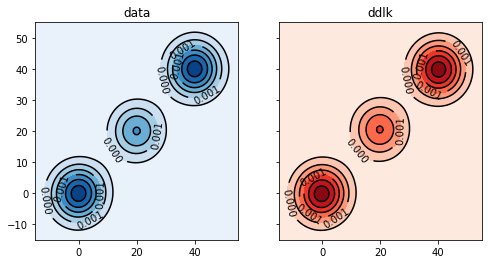

In [25]:
xmin, xmax = -15, 55
ymin, ymax = -15, 55

# Peform kernel density estimate
A, B = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([A.ravel(), B.ravel()])

fig, axarr = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# plot data
f = np.exp(np.reshape(kde_data.score_samples(positions.T), A.shape))
cfset = axarr[0].contourf(A, B, f, cmap='Blues')
cset = axarr[0].contour(A, B, f, colors='k')
axarr[0].clabel(cset, inline=1, fontsize=10)

# plot ddlk sampled knockoffs
f = np.exp(np.reshape(kde_ddlk.score_samples(positions.T), A.shape))
cfset = axarr[1].contourf(A, B, f, cmap='Reds')
cset = axarr[1].contour(A, B, f, colors='k')
axarr[1].clabel(cset, inline=1, fontsize=10)

axarr[0].set_title('data')
axarr[1].set_title('ddlk')
plt.show()

# Perform variable selection

In [27]:
# set dataloaders to prediction mode
trainloader.dataset.set_mode('prediction')
valloader.dataset.set_mode('prediction')
testloader.dataset.set_mode('prediction')

# extract training and validation data
xTr, yTr = utils.extract_data(trainloader)
xVal, yVal = utils.extract_data(valloader)
## concatenate xTr and xVal to use in HRT
xTr = torch.cat([xTr, xVal], axis=0)
yTr = torch.cat([yTr, yVal], axis=0)
xTr = xTr.float()
xVal = xVal.float()

# extract test data
xTe, yTe = utils.extract_data(testloader)
xTe = xTe.float()

with torch.no_grad():
    xTr_tilde = q_knockoff.sample(xTr).cpu().numpy()
    xTe_tilde = q_knockoff.sample(xTe).cpu().numpy()

knockoff_test = hrt.HRT_Knockoffs(mixture_prop=0.5)

knockoff_test.fit(xTr, yTr, xTr_tilde, tqdm=tqdm)

In [28]:
knockoff_statistics = knockoff_test.score(xTe, yTe, xTe_tilde, tqdm=tqdm)

In [29]:
knockoff_statistics = pd.Series(knockoff_statistics)
results = pd.DataFrame(knockoff_statistics, columns=['statistic']).join(
    pd.DataFrame(trainloader.dataset.beta.flatten(),
                 index=np.arange(trainloader.dataset.beta.flatten().shape[0]),
                 columns=['beta']))
results.index.name = 'feature'

In [30]:
results

,statistic,beta
feature,,
0,0.004336,0.000000
1,-0.000615,0.000000
2,-0.002166,0.000000
3,1.620650,-2.236068
4,0.004006,0.000000
5,-0.002536,0.000000
6,0.001563,0.000000
7,0.002257,0.000000
8,0.034678,0.000000
